## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

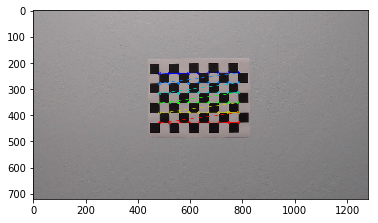

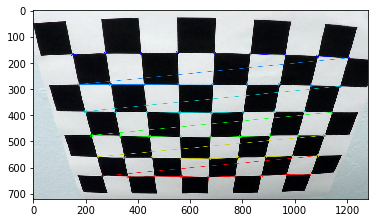

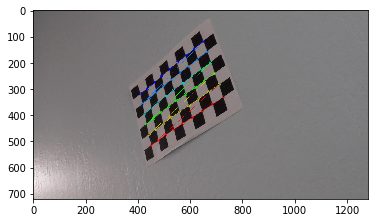

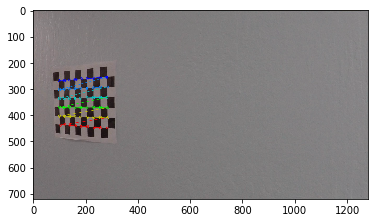

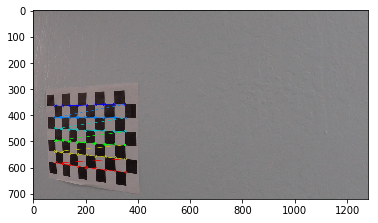

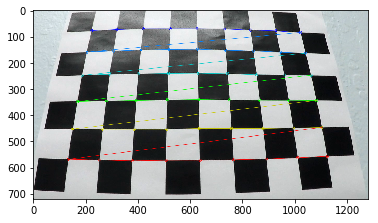

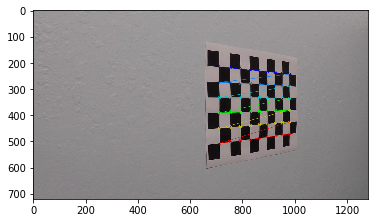

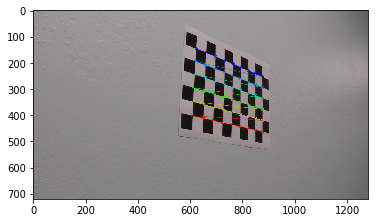

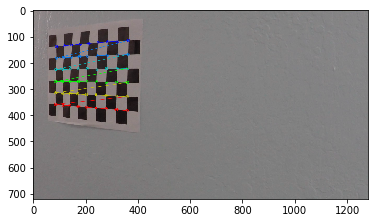

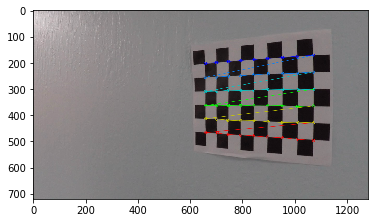

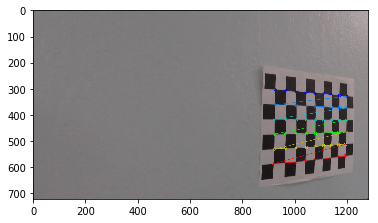

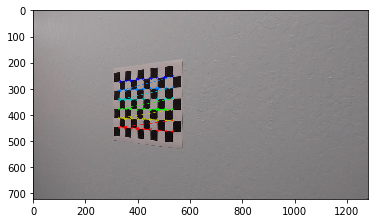

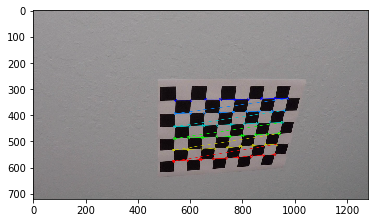

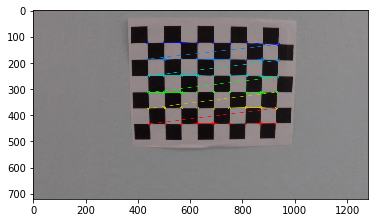

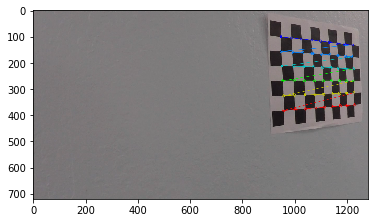

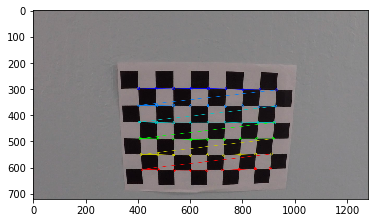

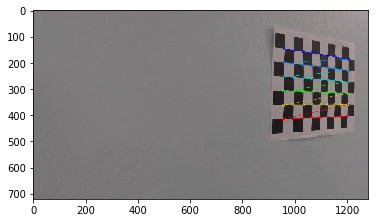

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

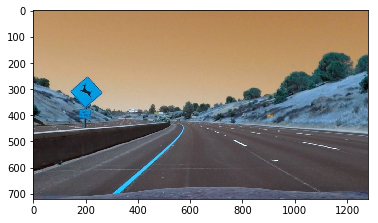

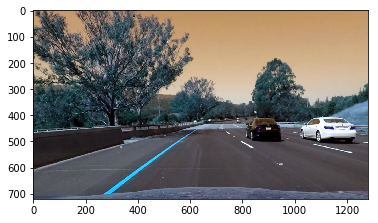

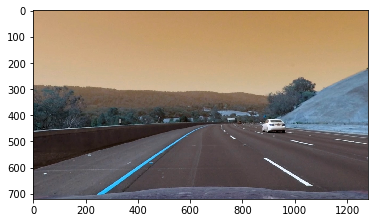

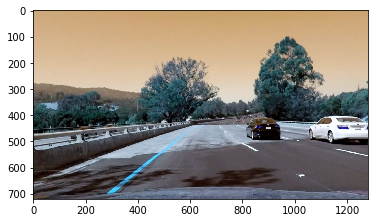

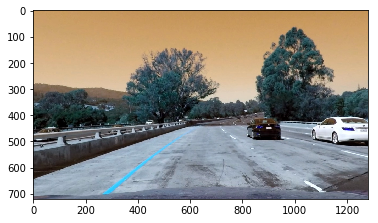

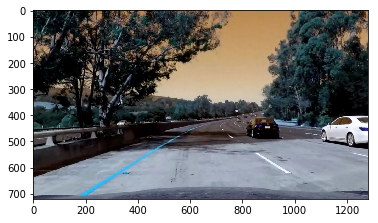

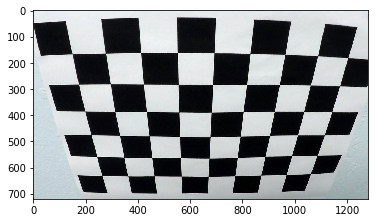

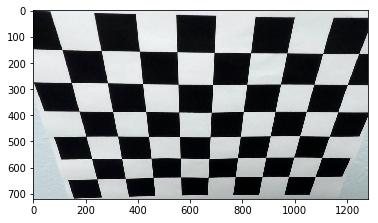

In [2]:
#compute camera distortion data
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#undistort imaged
def undistort(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

test_images = glob.glob('test_images/test*.jpg')

for fname in test_images:
    img=cv2.imread(fname)
    img=undistort(img)
    plt.imshow(img)
    plt.show()

# more visible undistortion:
img = cv2.imread(images[1])
plt.imshow(img)
plt.show()
img = undistort(img)
plt.imshow(img)
plt.show()


In [3]:
#compute sobel binary images from grayscale
def sobel(img, sx, sy, kernel=3):
    sobel = cv2.Sobel(img, cv2.CV_64F, sx, sy, ksize=kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

#apply the threshold
def threshold(img, thresh_min=30, thresh_max=255):
    #img2=np.copy(img)
    img2 = np.zeros_like(img)
    img2[(img >= thresh_min) & (img <= thresh_max)] = 1
    return img2


In [4]:
#return single magnitude
def magnitude_sobel(sobel):
    return np.absolute(sobel)
#return overll magnitude
def magnitude_sobelxy(sobelx, sobely):
    #if input is uint8 or float8 the conversion may be necessary
    sobelx=np.int32(sobelx)
    sobely=np.int32(sobely)
    val = np.sqrt(sobelx**2 + sobely**2)
   # print (val)
    return val

In [5]:
#sobel gradient direction

def sobel_dir(sobelx, sobely):
    sobelx=np.uint32(sobelx)
    sobely=np.uint32(sobely)
    return np.arctan2(sobely, sobelx)

In [6]:
#defining the function

def mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelxbinary = threshold(sobel(gray, 1, 0))
    sobelybinary = threshold(sobel(gray, 0, 1))

    sobelx=np.absolute(sobel(gray, 1, 0, kernel=15))
    sobely=np.absolute(sobel(gray, 0, 1, kernel=15))
    sobelmag = np.uint8(magnitude_sobelxy(sobelx, sobely))
    sobelmag_bin=threshold(sobelmag,30,255)
    
    sobel_grad=sobel_dir(sobelx,sobely)
    sobelgrad_bin=threshold(sobel_grad, 0.7, 1.3)

    combined_lax=np.zeros_like(sobelxbinary)
    combined_lax[((sobelxbinary==1)&(sobelybinary==1))|((sobelgrad_bin==1)&(sobelmag_bin==1))]=1
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    S_bin = threshold(S,100,255)
    S_mask=np.zeros_like(S_bin)
    S_mask[(S_bin==1)]=1
    S_mask[combined_lax==1]=1
    return S_mask

In [7]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    for x1,y1,x2,y2 in line:
        sl = (y2 - y1) / (x2 - x1)
    return sl

def x_intercept(slope, line):
    for x1, y1, x2, y2 in line:
        return x1-(y1 / slope)

def horizon_intercept_x(horizon_y, slope, intercept):
    return (horizon_y / slope) + intercept

def reject_outliers(data, m = 2.):
    try:
        d = np.abs(data[:,1] - np.median(data[:,1]))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    except:
        return data

def extremes(shape, m, c):
    return (c+(shape[0]/m), shape[0],
            c+(shape[0]*5/8/m), shape[0]*5/8)
    

def draw_lines(img, lines, dx_slope, sx_slope, tolerance, horizon_intersection, horizon_tolerance,
               thickness=10, color=[255, 0, 0]):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lines_bucket_dx = []
    lines_bucket_sx = []
    lines_sx=[]
    lines_dx=[]
    
    out_lines = []
    
    for line in lines:
        slope_line = slope(line)
        intercept_line = x_intercept(slope_line, line)
        x_horizon = horizon_intercept_x(img.shape[0]/2, slope_line, intercept_line)
        
        if abs(sx_slope - slope_line) < tolerance and abs(horizon_intersection - x_horizon) < horizon_tolerance:
            lines_bucket_sx.append(line)
            lines_sx.append([slope_line, intercept_line])
#            print("sx:", x_horizon, intercept_line)
                                   
        if abs(dx_slope - slope_line) < tolerance and abs(horizon_intersection - x_horizon) < horizon_tolerance:
            lines_bucket_dx.append(line)
            lines_dx.append([slope_line, intercept_line])
#            print("dx:", x_horizon, intercept_line)
                                   
    sx = np.array(lines_sx)
    dx = np.array(lines_dx)
    sx_clean = reject_outliers(sx)
    dx_clean = reject_outliers(dx)
    
#    print("dx:", dx, "dx_clean:", dx_clean)
    try:
        sx_mean = [np.mean(sx_clean[:,0]), np.mean(sx_clean[:,1])]
        sx1, sy1, sx2, sy2 = extremes(img.shape, sx_mean[0], sx_mean[1])
        cv2.line(img, (int(sx1), int(sy1)), (int(sx2), int(sy2)), color,thickness)
    except:
        print("missing sx line in frame")
#    print("mean:", dx_mean)
    
    
    try:
        dx_mean = [np.mean(dx_clean[:,0]), np.mean(dx_clean[:,1])]
        dx1, dy1, dx2, dy2 = extremes(img.shape, dx_mean[0], dx_mean[1])
        cv2.line(img, (int(dx1), int(dy1)), (int(dx2), int(dy2)), color,thickness)
    except:
        print("missing dx line in frame")

    for line in lines_bucket_sx:
        for x1,y1,x2,y2 in line:
            out_lines.append(line)

    for line in lines_bucket_dx:
        for x1,y1,x2,y2 in line:
            out_lines.append(line)
    
    return [[sx1, sy1], [sx2, sy2], [dx2, dy2], [dx1, dy1]]
            
#    for line in out_lines:
#        for x1,y1,x2,y2 in line:
#            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, slope_dx, slope_sx, tolerance,
                expected_horizon_intersection, horizon_tolerance):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    points = draw_lines(line_img, lines, slope_dx, slope_sx, tolerance, expected_horizon_intersection, horizon_tolerance)
    return (line_img, points)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [8]:
import os

def pipeline(img):
    
    blur = gaussian_blur(img, 5)

    canny_img = canny(blur, 100,200)
    
    sides = 200
    
    canny_cut = region_of_interest(canny_img,
                                   [np.array([[img.shape[1]-sides, img.shape[0]*3/5],
                                              [sides,img.shape[0]*3/5],
                                              [50, img.shape[0]],
                                              [img.shape[1]-50, img.shape[0]]],
                                                        np.int32)])
 #   canny_color = np.dstack(canny_img, canny_img, canny_img)
    (line_img, points) = hough_lines(canny_cut, rho = 1, theta = np.pi/180, threshold = 10, min_line_len = 10, max_line_gap = 100,
                          slope_dx = -0.6, slope_sx = 0.6, tolerance = 0.3,
                          expected_horizon_intersection = 0.5 * img.shape[1], horizon_tolerance = 0.1* img.shape[1])
    out_img = weighted_img(line_img, img)
    return (out_img, points)

/home/gaber/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/home/gaber/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/gaber/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


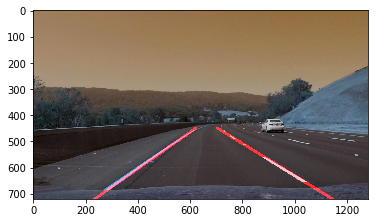

In [9]:
(image, points)=pipeline(cv2.imread(test_images[2]))
plt.imshow(image)
plt.show()

In [29]:
points = np.float32(points)
points2 = np.float32([[image.shape[1]-200,image.shape[0]],[image.shape[1]-200,200],[200,200],[200,image.shape[0]]])
points = np.float32([[545, 460],
                    [735, 460],
                    [1280, 700],
                    [0, 700]])
    # Four desired coordinates
points2 = np.float32([[0, 0],
                     [1280, 0],
                     [1280, 720],
                     [0, 720]])

In [30]:
print(points)
print(points2)

[[  545.   460.]
 [  735.   460.]
 [ 1280.   700.]
 [    0.   700.]]
[[    0.     0.]
 [ 1280.     0.]
 [ 1280.   720.]
 [    0.   720.]]


In [31]:
M = cv2.getPerspectiveTransform(points,points2)
Minv = cv2.getPerspectiveTransform(points2, points)

def warped(image):
    return cv2.warpPerspective(image,M,(image.shape[1],image.shape[0]))

def unwarped(image):
    return cv2.warpPerspective(image,Minv,(image.shape[1],image.shape[0]))


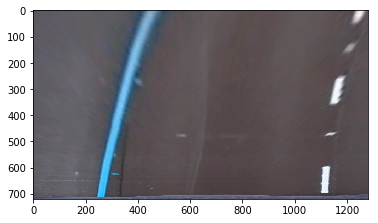

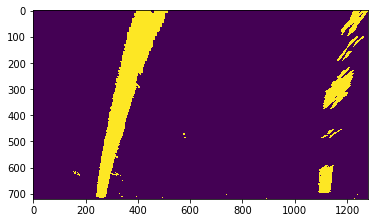

In [32]:
img = cv2.imread(test_images[2])
dist = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
masked = mask(img)
dst = cv2.warpPerspective(masked,M,(masked.shape[1],masked.shape[0]))
plt.imshow(dist)
plt.show()
plt.imshow(dst)
plt.show()

In [69]:
def find_first_fit(image):
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, rightx, nonzerox, nonzeroy, out_img)

In [70]:
(left_inds, right_inds, left_fit, right_fit, leftx, rightx, nonzerox, nonzeroy, out_img) = find_first_fit(dst)

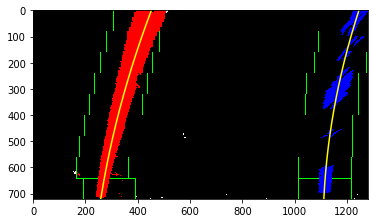

In [71]:
# Generate x and y values for plotting
ploty = np.linspace(0, dst.shape[0]-1, dst.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
out_img[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [126]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_fit(image, left_lane_inds, right_lane_inds, left_fit, right_fit):
    out_img = np.dstack((image, image, image))*255
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    return (left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy, out_img)

In [127]:
(left_inds, right_inds, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy, out_img) = find_fit(
    dst, left_inds, right_inds, left_fit, right_fit)

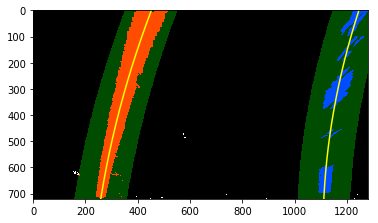

In [76]:
# Create an image to draw on and an image to show the selection window
window_img = np.zeros_like(out_img)
# Color in left and right line pixels

out_img[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
out_img[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-100, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+100, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-100, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+100, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [94]:
def calculate_curvature(leftx, rightx):
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                   for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                   for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return str("{:.1f}".format(left_curverad)) + "m " + str("{:.1f}".format(right_curverad)) + "m"


In [95]:
print( calculate_curvature(leftx, rightx))


602.4m 605.2m


In [106]:
def lane_image(image, mask, left_fitx, right_fitx, ploty, leftx, rightx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    font = cv2.FONT_HERSHEY_SIMPLEX
    newwarp = unwarped(color_warp)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result,calculate_curvature(leftx, rightx),(30,60), font, 2,(255,255,255),2,cv2.LINE_AA)

    return result
    #return newwarp



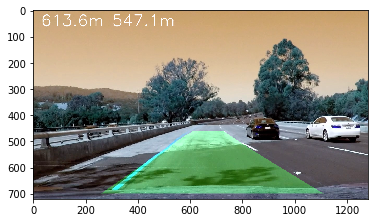

In [107]:
result=lane_image(img, dst, left_fitx, right_fitx, ploty, leftx, rightx)
plt.imshow(result)
plt.show()

In [133]:
left_inds, right_inds, leftx, lefty, rightx, righty, left_fit, right_fit, margin = (0,0,0,0,0,0,0,0,0)
def process_image(image):
    global left_inds, right_inds, leftx, lefty, rightx, righty, left_fit, right_fit, margin
    self=process_image
    dist = warped(image)
    masked = mask(dist)

    try:
        (left_inds, right_inds, left_fit, right_fit, rightx, _, rightx, _, _, _, _) = find_fit(
    masked, left_inds, right_inds, left_fit, right_fit)
        (left_inds, right_inds, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy, out_img)
    except:
        (left_inds, right_inds, left_fit, right_fit, rightx, righty, _, _, _) = find_first_fit(masked)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result = lane_image(image, masked, left_fitx, right_fitx, ploty, rightx, righty)
    return result

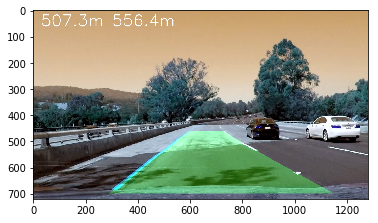

In [134]:
del left_inds
img=cv2.imread(test_images[3])
result=process_image(img)
plt.imshow(result)
plt.show()

In [135]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_video(input_vid, output_vid):
    global left_inds
    # make sure to perform a window search th first time around
    try:
        del left_inds
    except:
        pass
    clip1 = VideoFileClip(input_vid)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_vid, audio=False)
    
    

In [138]:
video1="project_video.mp4"
video2="challenge_video.mp4"
video3="harder_challenge_video.mp4"

process_video(video1,"out/"+ video1)
process_video(video2,"out/"+ video2)
process_video(video3,"out/"+ video2)

[MoviePy] >>>> Building video out/project_video.mp4
[MoviePy] Writing video out/project_video.mp4


100%|█████████▉| 1260/1261 [04:33<00:00,  4.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/project_video.mp4 

CPU times: user 15min 11s, sys: 12.8 s, total: 15min 24s
Wall time: 4min 34s
[MoviePy] >>>> Building video out/challenge_video.mp4
[MoviePy] Writing video out/challenge_video.mp4


100%|██████████| 485/485 [01:40<00:00,  4.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/challenge_video.mp4 

CPU times: user 5min 46s, sys: 1.2 s, total: 5min 47s
Wall time: 1min 41s
[MoviePy] >>>> Building video out/challenge_video.mp4
[MoviePy] Writing video out/challenge_video.mp4


100%|█████████▉| 1199/1200 [04:49<00:00,  3.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/challenge_video.mp4 

CPU times: user 15min 23s, sys: 8.88 s, total: 15min 32s
Wall time: 4min 50s


In [139]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("out/"+ video1))